In [324]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as LA

In [2]:
# structure definition
period_x = 0.357
period_y = 0.357

In [32]:
# Incidence wave
wavelength = 0.530
k0 = np.pi*2 / wavelength

AOI = np.deg2rad(20)
POI = 0

k0x = np.sin(AOI) * np.cos(POI)
k0y = np.sin(AOI) * np.sin(POI)
k0z = np.cos(AOI)

k0v = np.array([k0x, k0y, k0z])

normal_vec = np.array([0, 0, 1], dtype='float')

pol_vec_s = np.cross(normal_vec, k0v)

if k0z==1:
    pol_vec_s = np.array([0, 1, 0], dtype='float')

pol_vec_p = np.cross(pol_vec_s, k0v)

pol_vec_s/=np.sqrt(np.sum(pol_vec_s**2))
pol_vec_p/=np.sqrt(np.sum(pol_vec_p**2))


In [33]:
def vis_vec(v, axis1=0, axis2=2, label=''):
    plt.plot([0, v[axis1]], [0, v[axis2]], '-o', label=label)

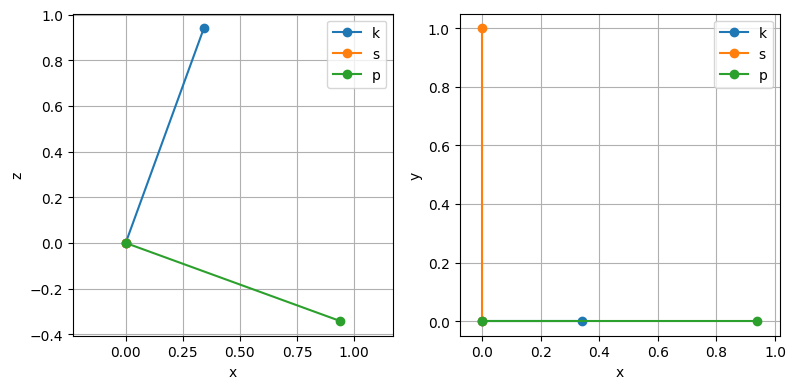

In [34]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
vis_vec(k0v, label='k')
vis_vec(pol_vec_s, label='s')
vis_vec(pol_vec_p, label='p')
plt.xlabel('x')
plt.ylabel('z')
plt.axis('equal')
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
vis_vec(k0v, axis2=1, label='k')
vis_vec(pol_vec_s, axis2=1, label='s')
vis_vec(pol_vec_p, axis2=1, label='p')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.tight_layout()
plt.grid()
plt.legend()

In [35]:
# Special Frequency
gx = wavelength / period_x
gy = wavelength / period_y

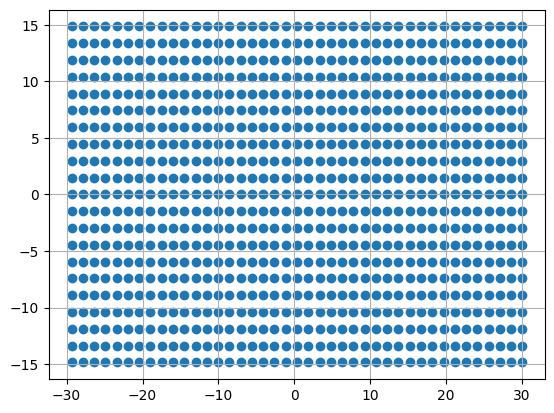

In [67]:

# Harmonics and mode number
num_harmonics_x = 20  # num of x harmonics -num to +num
num_harmonics_y = 10  # num of y harmonics -num to +num

num_modes_x = num_harmonics_x*2+1  # num of x modes
num_modes_y = num_harmonics_y*2+1  # num of y modes

num_modes = num_modes_x * num_modes_y  # total modes


def ind2mode(id):
    id = id % num_modes
    ix = id % num_modes_x
    iy = id // num_modes_x
    mx = ix - num_harmonics_x
    my = iy - num_harmonics_y
    return mx, my


mx, my = ind2mode(np.arange(num_modes))



kx = mx * gx + k0x
ky = my * gy + k0y
plt.scatter(kx, ky)
plt.grid()
plt.show()


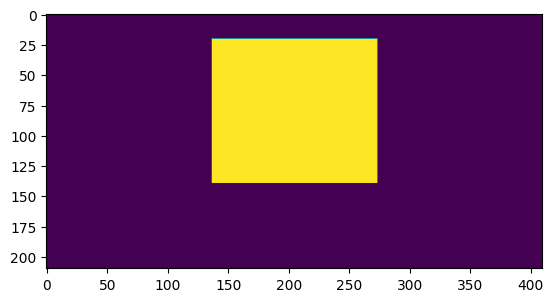

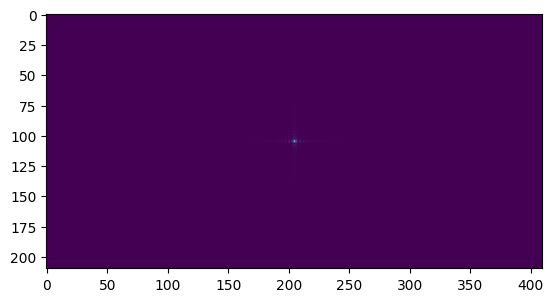

In [310]:
nx = num_modes_x*10
ny = num_modes_y*10
x = np.arange(nx)/nx*period_x
y = np.arange(ny)/ny*period_y
x, y = np.meshgrid(x, y)

mask = (x>period_x/3) *  (y>period_y/10) * (x<2*period_x/3) *  (y<2*period_y/3) 
plt.imshow(mask)
plt.show()

n0 = 1
n1 = 2

er = (n1**2 - n0**2) * mask + n0**2
ur = np.ones([ny, nx])

ft_er = np.fft.fft2(er)
ft_ur = np.fft.fft2(ur)
plt.imshow(np.fft.fftshift(np.abs(ft_er)))
plt.show()

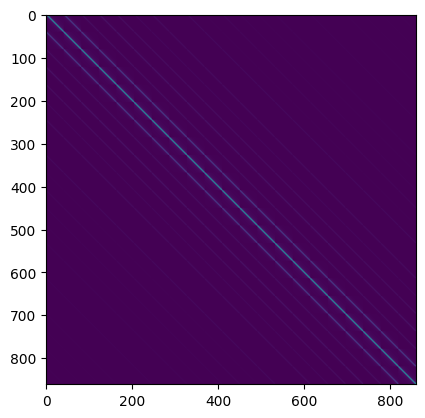

In [315]:
def conv_matrix(a):
    ind_prime = np.arange(num_modes)[None, :]
    ind = np.arange(num_modes)[:, None]
    mx_prime, my_prime = ind2mode(ind_prime)
    mx, my = ind2mode(ind)
    ind_x = (mx-mx_prime)%nx
    ind_y = (my-my_prime)%ny
    conv = a[ind_y, ind_x]/nx/ny
    return conv
conv_er = conv_matrix(ft_er)
conv_ur = conv_matrix(ft_ur)
plt.imshow(np.abs(conv_er))

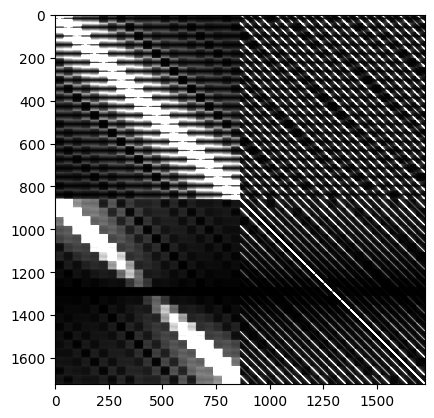

In [332]:
KX = np.diag(kx)
KY = np.diag(ky)

def Pmat(er, ur):
    er_inv = np.linalg.inv(er)
    P11 = KX@er_inv@KY
    P12 = ur-KX@er_inv@KX
    P21 = KY@er_inv@KY-ur
    P22 = -KY@er_inv@KX
    P = np.block([[P11, P12],[P21, P22]])
    return P

def PQmat(er, ur):
    P = Pmat(er, ur)
    Q = Pmat(ur, er)
    return P, Q

P, Q = PQmat(conv_er, np.eye(conv_er.shape[0]))

omega2 = P@Q
plt.imshow(np.abs(omega2), vmax=1, cmap='gray')

In [326]:
LAM2, W = LA.eig(omega2)

In [327]:
LAM = np.diag(np.sqrt(LAM2))

In [328]:
sorted_indices = np.argsort(-np.abs(LAM2))

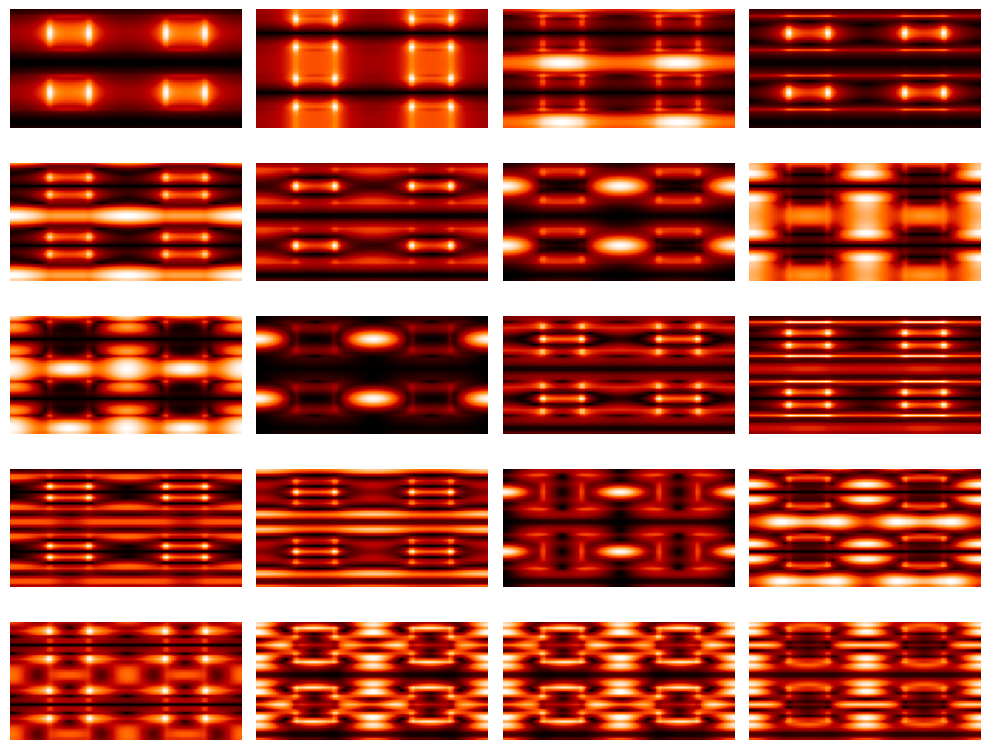

In [329]:
plt.figure(figsize=(10, 8))
for i in range(20):
    plt.subplot(5, 4, i+1)
    w = W[:, sorted_indices[i]][:W.shape[0]//2].reshape([num_modes_y, num_modes_x])
    field = np.abs(np.fft.ifft2(w))
    plt.imshow(np.block([
        [field, field],
        [field, field],
    ]), cmap='gist_heat')
    plt.axis(False)
plt.tight_layout()

In [321]:
V=Q@W@(np.linalg.inv(LAM))

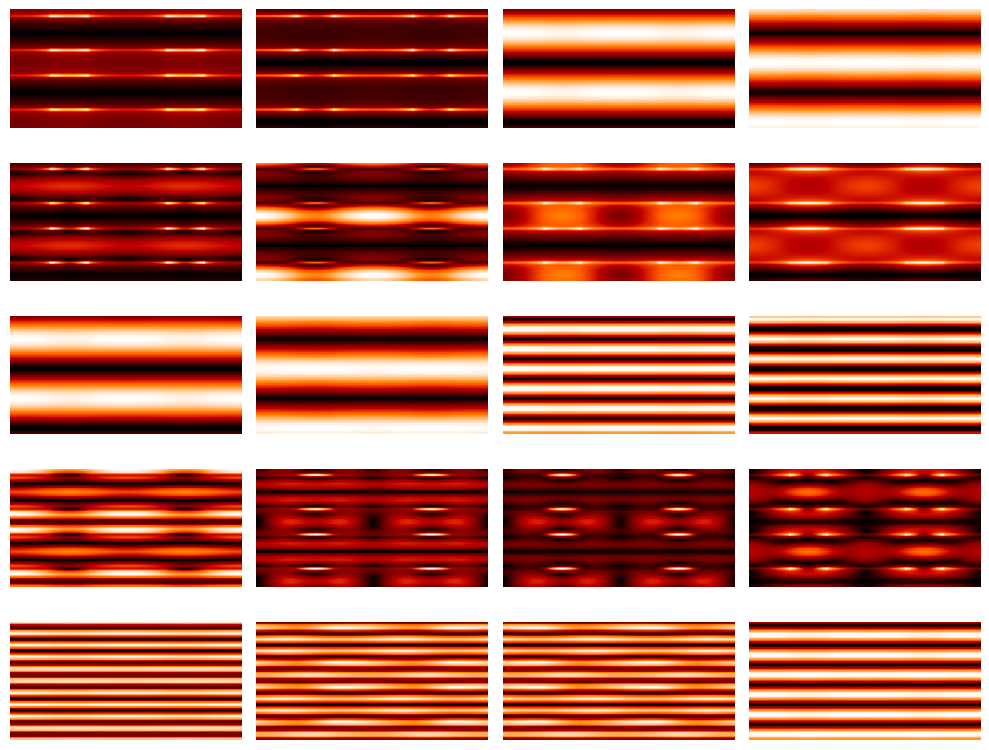

In [322]:
plt.figure(figsize=(10, 8))
for i in range(20):
    plt.subplot(5, 4, i+1)
    v = V[:, sorted_indices[i]][:V.shape[0]//2].reshape([num_modes_y, num_modes_x])
    field = np.abs(np.fft.ifft2(v))
    plt.imshow(np.block([
        [field, field],
        [field, field],
    ]), cmap='gist_heat')
    plt.axis(False)
plt.tight_layout()

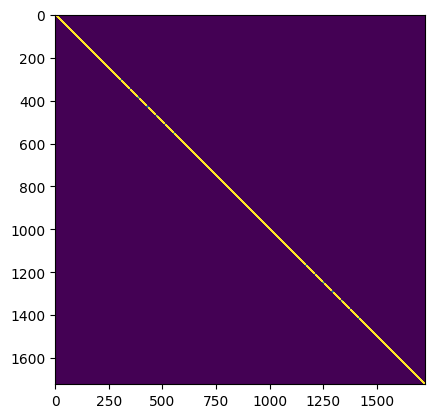

In [335]:
P0, Q0 = PQmat(np.eye(conv_er.shape[0]), np.eye(conv_er.shape[0]))
Omega2_0 = P0@Q0
plt.imshow(np.abs(Omega2_0), vmax=1)

In [323]:
def BuildScatter(W, V, L):
    Wi = np.linalg.inv(W)
    Vi = np.linalg.inv(V)
    